<a href="https://colab.research.google.com/github/KarthikMukka96/cs666student/blob/main/CS666_assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

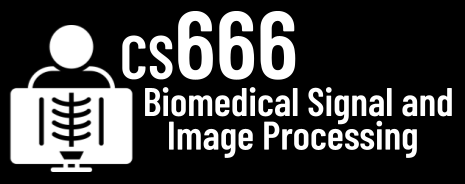
#Assignment 4

In [ ]:
# NAME: Karthik Mukka

In [ ]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [ ]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# our imports include sklearn this time
import mahotas as mh
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [ ]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [ ]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [ ]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

The images dimensions are(1858, 2090)


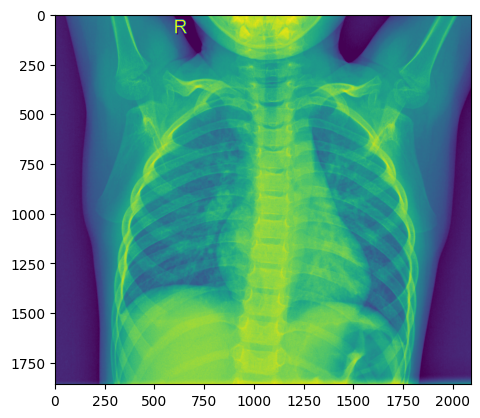

In [ ]:
# TODO: Please display this image and print the dimensions!
plt.imshow(img)
print(f'The images dimensions are{img.shape}')

**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [ ]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [ ]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) YOUR ANSWER
#loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3]) 
#We read the image from normal and pneumonia and covid and later we change the color.
# TODO: Operation 2) YOUR ANSWER
#we did some resize to the dimensions 300*300 .
# TODO: Operation 3) YOUR ANSWER
#The last line of the code helps to fill the matrics by giving specified location

In [ ]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

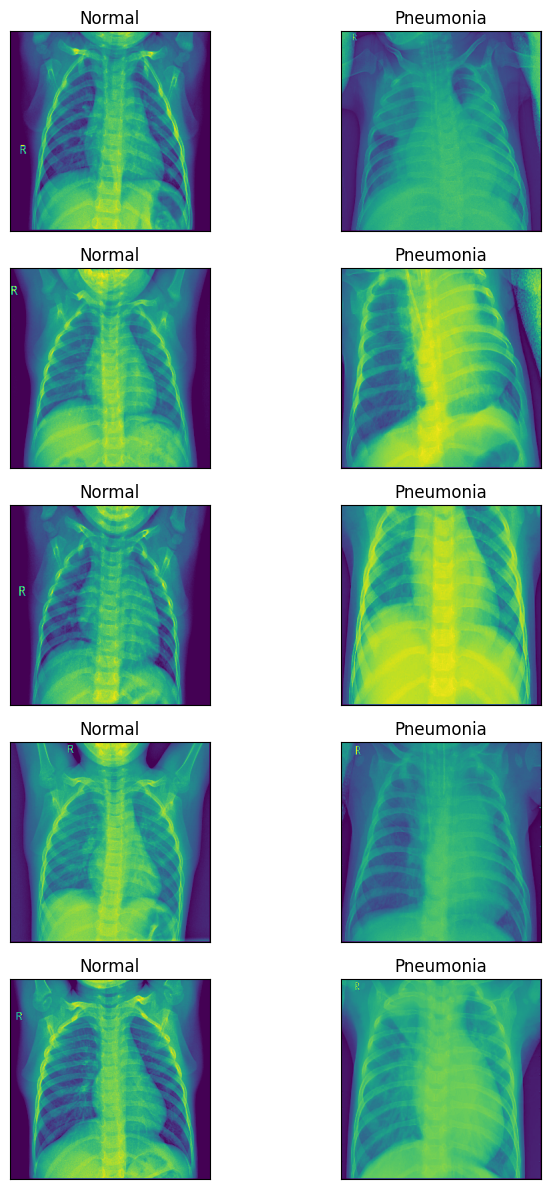

In [ ]:
# TODO: YOUR CODE
fig, axs = plt.subplots(5, 2, figsize=(8, 12))

# plot normal images
for i in range(5):
    axs[i, 0].imshow(data[0][i])
    axs[i, 0].set_title('Normal')

# plot pneumonia images
for i in range(5):
    axs[i, 1].imshow(data[1][i])
    axs[i, 1].set_title('Pneumonia')

# remove the axis ticks and labels
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


plt.tight_layout()
plt.show()


**Task 3:** Setup training and testing data. [15 Points]

In [ ]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [ ]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [ ]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.concatenate((np.zeros(60, dtype=int), np.ones(60, dtype=int), np.full(60, 2, dtype=int)))



In [ ]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [ ]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test= np.concatenate((np.zeros(40, dtype=int), np.ones(40, dtype=int), np.full(40, 2, dtype=int)))

**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [ ]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [ ]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [ ]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [ ]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [ ]:
# TODO: YOUR ANSWER
"""Random Forest builds multiple decision trees, each tree is trained on a subset of the training data using a random selection of features. This randomness helps to reduce overfitting and improve generalization performance."""

#ref google.com

'Random Forest builds multiple decision trees, each tree is trained on a subset of the training data using a random selection of features. This randomness helps to reduce overfitting and improve generalization performance.'

In [ ]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [ ]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [ ]:
# TODO: YOUR ANSWER
"""Yes, It is good and surprising to see such an accuracy on a small data"""

'Yes, It is good and surprising to see such an accuracy on a small data'

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [ ]:
X_test_covid_only = np.zeros( (99, 300*300 ), dtype=np.float32)

In [ ]:
number = 0

for img in data[2][100:]:
  img= img.ravel() 
  img /= img.max()  
  X_test_covid_only[number] = img
  number += 1

In [ ]:
clf.score(covid_only, [2]*99 )

0.9494949494949495

In [ ]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?
#Because these images are not covid so they failed the classifier.

In [ ]:
# TODO: YOUR CODE AND YOUR ANSWER

In [ ]:
predict = clf.predict(covid_only)

In [ ]:
predict

array([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
wrong_class= np.where(predict != 2)
wrong_class

(array([ 8, 25, 32, 61, 86]),)

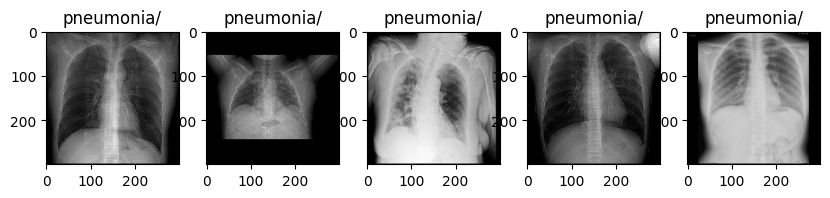

In [ ]:
plt.figure(figsize=(10, 10))
for idx, i in enumerate(wrong_class[0]):
    plt.subplot(5, 5, idx+1)
    plt.imshow(covid_only[i].reshape(300, 300), cmap='gray')
    plt.axis('on')
    plt.title(label)
    
plt.show()

In collab with Sravani.




In [ ]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw

#Collaboration with Nishanth Paul B